<a href="https://colab.research.google.com/github/yoheshkannan/ML/blob/master/Pneumonia_Detection_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pneumonia Detection Using transfer Learning**

In [1]:
# upload authentication key to load data from kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# download the data from kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 34.5MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.9MB/s]


In [7]:
# unzip the data
from zipfile import ZipFile
file_name = 'chest-xray-pneumonia.zip'

with ZipFile(file_name , 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [10]:
# import necessary libraries
import matplotlib.pyplot as plt
import os
import cv2

In [13]:
# A function to viusalize both normal and pneumonia chest_Xray
labels = ['NORMAL','PNEUMONIA']
def plot_img(path,n):
  for label in labels:
    img_path = os.path.join(path,label)
    x = os.listdir(img_path)
    plt.figure(figsize=(10,10))
    for i in range(n):
      plt.subplot(2,n,i+1)
      path_new = ''
      path_new = os.path.join(img_path,x[i])
      image = plt.imread(path_new)
      plt.imshow(image,cmap='gray')
      plt.title(label)
      plt.axis('off')
    plt.show()


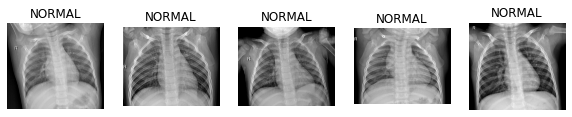

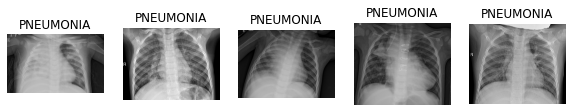

In [14]:
# visualize the images
plot_img('/content/chest_xray/train',5)

In [ ]:
# Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#create image data augmentation generator for train set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range =0.3,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
#create image data augmentation generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Image Data generator flow_from_directory (train_data)
train_data = train_datagen.flow_from_directory('/content/chest_xray/train', #directory
                                               target_size=(224,224), #resize the image (224,224)
                                               batch_size = 32, #no.of.images to extract from folder for every batch
                                               class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
# Image Data generator flow_from_directory (test_data)
test_data = test_datagen.flow_from_directory('/content/chest_xray/test/',
                                             target_size=(224,224),
                                             batch_size =32,
                                             shuffle = False,
                                             class_mode = 'categorical')

Found 624 images belonging to 2 classes.


**Transfer Learning**

While building a CV application rather than training the weights from scratch from random initialization, we often make much faster progress if we download weights that someone else has already trained on the network architecture and use that that as pre training and transfer that to a new task that we might be interested in.

**VGG-16**

VGG-16 is one of the most popular pre-trained models for image classification. It was developed at the Visual Graphics Group at the university of oxford and introduced in the ILSVRC 2014 conference.

In [ ]:
# import the necessary packages
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Loading the VGG-16 base model
vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Making the vgg-16 layers non-trainable
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
# Flatten the output layer to 1 layer
x = Flatten()(vgg16.output)
# Add a fully connected layer with 512 hidden units with relu activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.3
x = Dropout(0.3)(x)
# Add a final softmax layer for classification
x = Dense(2, activation='softmax')(x)
# create model from inputs and outputs
model = Model(vgg16.input, x)
# compile the model 
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# to review the summary of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
# Training a model
hist = model.fit(train_data, epochs=15, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                                                                 ModelCheckpoint('best_model.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')],
          validation_data=(test_data))

Epoch 1/15
163/163 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.9214
Epoch 00001: val_accuracy improved from -inf to 0.90385, saving model to best_model.hdf5
163/163 [==============================] - 96s 590ms/step - loss: 0.2876 - accuracy: 0.9214 - val_loss: 0.2876 - val_accuracy: 0.9038
Epoch 2/15
163/163 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9509
Epoch 00002: val_accuracy improved from 0.90385 to 0.90865, saving model to best_model.hdf5
163/163 [==============================] - 97s 592ms/step - loss: 0.1325 - accuracy: 0.9509 - val_loss: 0.2508 - val_accuracy: 0.9087
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9559
Epoch 00003: val_accuracy did not improve from 0.90865
163/163 [==============================] - 96s 587ms/step - loss: 0.1223 - accuracy: 0.9559 - val_loss: 0.5081 - val_accuracy: 0.8253
Epoch 4/15
163/163 [==============================] - ETA: 0s - loss: 0.10

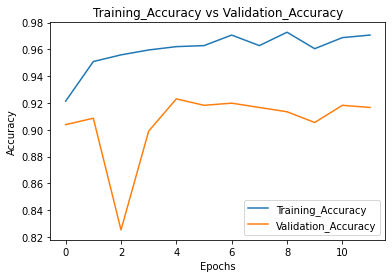

In [ ]:
# plotting training vs validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training_Accuracy','Validation_Accuracy'])
plt.title('Training_Accuracy vs Validation_Accuracy')
plt.show()

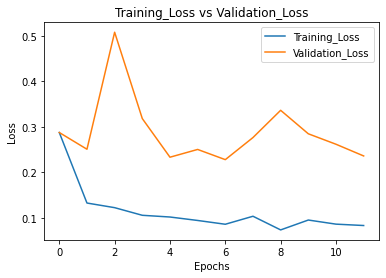

In [ ]:
# plotting training vs validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training_Loss','Validation_Loss'])
plt.title('Training_Loss vs Validation_Loss')
plt.show()

In [ ]:
# load the saved model
from keras.models import load_model
final_model = load_model('best_model.hdf5')

In [ ]:
# estimate loss, accuracy for test_data
loss,acc = final_model.evaluate(test_data)
print('Model Loss:', loss)
print('Model Accuracy:',acc)

20/20 [==============================] - 4s 223ms/step - loss: 0.2333 - accuracy: 0.9231
Model Loss: 0.2332882583141327
Model Accuracy: 0.9230769276618958


In [ ]:
# Make prediction
pred =final_model.predict(test_data,verbose=1)

20/20 [==============================] - 5s 228ms/step


In [ ]:
# Identify the predicted classes from pred
import numpy as np
prediction = np.argmax(pred, axis=-1)

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_true = test_data.classes, y_pred=prediction)
conf

array([[201,  33],
       [ 15, 375]])

In [ ]:
# Function to plot confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[201  33]
 [ 15 375]]


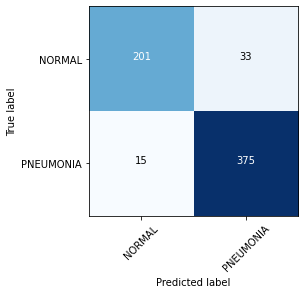

In [ ]:
# Visualizing confusion matrix graphically
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=conf, classes=cm_plot_labels, title='')

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_true = test_data.classes, y_pred = prediction))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       234
           1       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



**Inception V3**

GoogleNet or InceptionV3 is the third edition of Google's Inception CNN. It was secured 1st rank at ILSVRC. At only 7 million parameters, it was much smaller than the prevalent models like VGG and AlexNet. The introduction of the 1*1 convolution operations reduces the parameter drastically.

In [ ]:
# import InceptionV3 
from keras.applications.inception_v3 import InceptionV3

In [ ]:
# Loading the Inception-V3 base model
inceptionv3_basemodel = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Making the Incetion-V3 layers non-trainable
for layer in inceptionv3_basemodel.layers:
  layer.trainable = False

In [ ]:
# Flatten the output layer to 1 layer
x_incep = Flatten()(inceptionv3_basemodel.output)
# Add a fully connected layer with 1024 hidden units with relu activation
x_incep = Dense(1024, activation='relu')(x_incep)
# Add a dropout rate of 0.3
x_incep = Dropout(0.3)(x_incep)
# Add a another fully connected layer with 512 hidden units with relu activations
x_incep = Dense(512, activation='relu')(x_incep)
# Add a dropout rate of 0.25
x_incep = Dropout(0.25)(x_incep)
# Add a final softmax layer for classification
x_incep = Dense(2, activation='softmax')(x_incep)
# create model from inputs and outputs
model_inception = Model(inceptionv3_basemodel.input, x_incep)
# compile the model
model_inception.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Review the summary of the model
model_inception.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# fit a model
hist_inception = model_inception.fit(train_data, epochs =15, batch_size=32,validation_data= test_data,
                 callbacks = [EarlyStopping(monitor='val_accuracy',patience=5),
                              ModelCheckpoint("InceptionV3_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')])

Epoch 1/15
163/163 [==============================] - ETA: 0s - loss: 7.5893 - accuracy: 0.7941
Epoch 00001: val_accuracy improved from -inf to 0.77404, saving model to InceptionV3_model.hdf5
163/163 [==============================] - 99s 606ms/step - loss: 7.5893 - accuracy: 0.7941 - val_loss: 1.1486 - val_accuracy: 0.7740
Epoch 2/15
163/163 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.8750
Epoch 00002: val_accuracy improved from 0.77404 to 0.84615, saving model to InceptionV3_model.hdf5
163/163 [==============================] - 97s 598ms/step - loss: 0.5241 - accuracy: 0.8750 - val_loss: 0.3803 - val_accuracy: 0.8462
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.9009
Epoch 00003: val_accuracy improved from 0.84615 to 0.87981, saving model to InceptionV3_model.hdf5
163/163 [==============================] - 100s 614ms/step - loss: 0.3154 - accuracy: 0.9009 - val_loss: 0.3478 - val_accuracy: 0.8798
Epoch 4/15
163/

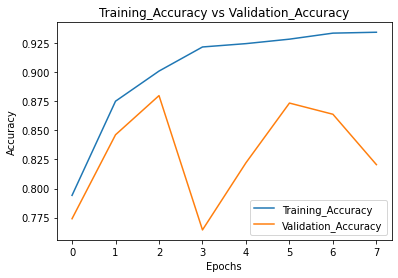

In [ ]:
# plotting training vs validation accuracy
plt.plot(hist_inception.history['accuracy'])
plt.plot(hist_inception.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training_Accuracy','Validation_Accuracy'])
plt.title('Training_Accuracy vs Validation_Accuracy')
plt.show()

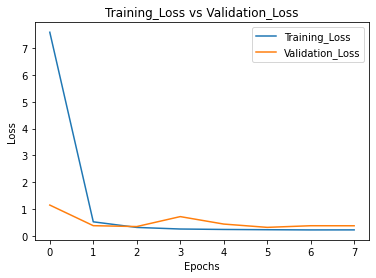

In [ ]:
# plotting training vs validation loss
plt.plot(hist_inception.history['loss'])
plt.plot(hist_inception.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training_Loss','Validation_Loss'])
plt.title('Training_Loss vs Validation_Loss')
plt.show()

In [ ]:
# load the saved model
final_model = load_model('InceptionV3_model.hdf5')
# estimate loss and accuracy of test _data
loss,acc = final_model.evaluate(test_data)
print('Model Loss:', loss)
print('Model Accuracy:',acc)

20/20 [==============================] - 5s 228ms/step - loss: 0.3478 - accuracy: 0.8798
Model Loss: 0.3477708697319031
Model Accuracy: 0.879807710647583


In [ ]:
# make prediction
pred =final_model.predict(test_data,verbose=1)

20/20 [==============================] - 4s 221ms/step


In [ ]:
# Identify the predicted classes
prediction = np.argmax(pred, axis=-1)

In [ ]:
# confusion matrix
conf = confusion_matrix(y_true = test_data.classes, y_pred=prediction)

Confusion matrix, without normalization
[[177  57]
 [ 18 372]]


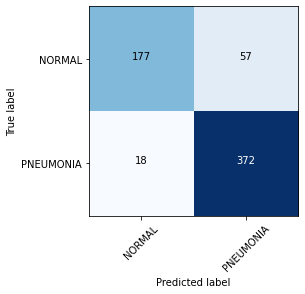

In [ ]:
# visualize confusion matrix graphically
plot_confusion_matrix(cm=conf, classes=cm_plot_labels, title='')

In [ ]:
# classification report
print(classification_report(y_true = test_data.classes, y_pred = prediction))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83       234
           1       0.87      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



**RestNet50**

The research team from microsoft is first to introduce the term "skip connection". The main motivation behind this model was to avoid poor accuracy as the model went on to become deeper. The usage of residual blocks helps to tackle the vanishing gradient problem to a very large extent.

In [ ]:
# import resnet50
from keras.applications import ResNet50
from keras.models import Sequential

In [ ]:
# intialise sequential model
resnet50_model = Sequential()
# load the base ResNet50 model
resnet50_model.add(ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3)))
# Flatten the output layer to 1 layer
resnet50_model.add(Flatten())
# Add a final softmax layer for classification
resnet50_model.add(Dense(2,activation='softmax'))
# make the resnet50 layers as non-trainable
resnet50_model.layers[0].trainable = False
#compile the model
resnet50_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#review the summary of the model
resnet50_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 200706    
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# training a model
hist_resnet = resnet50_model.fit(train_data, epochs =15, batch_size=32,validation_data= test_data,
                 callbacks = [EarlyStopping(monitor='val_accuracy',patience=5),
                              ModelCheckpoint("Resnet50_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')])

Epoch 1/15
163/163 [==============================] - ETA: 0s - loss: 0.7802 - accuracy: 0.7845
Epoch 00001: val_accuracy improved from -inf to 0.70032, saving model to Resnet50_model.hdf5
163/163 [==============================] - 95s 585ms/step - loss: 0.7802 - accuracy: 0.7845 - val_loss: 0.6739 - val_accuracy: 0.7003
Epoch 2/15
163/163 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8612
Epoch 00002: val_accuracy improved from 0.70032 to 0.78205, saving model to Resnet50_model.hdf5
163/163 [==============================] - 94s 577ms/step - loss: 0.3312 - accuracy: 0.8612 - val_loss: 0.4819 - val_accuracy: 0.7821
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8817
Epoch 00003: val_accuracy improved from 0.78205 to 0.87019, saving model to Resnet50_model.hdf5
163/163 [==============================] - 94s 577ms/step - loss: 0.2873 - accuracy: 0.8817 - val_loss: 0.3136 - val_accuracy: 0.8702
Epoch 4/15
163/163 [=====

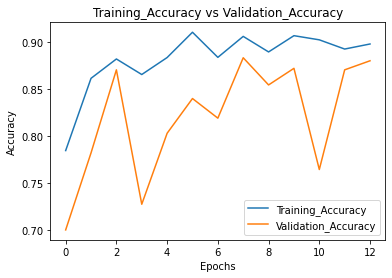

In [ ]:
# plotting training vs validation accuracy
plt.plot(hist_resnet.history['accuracy'])
plt.plot(hist_resnet.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training_Accuracy','Validation_Accuracy'])
plt.title('Training_Accuracy vs Validation_Accuracy')
plt.show()

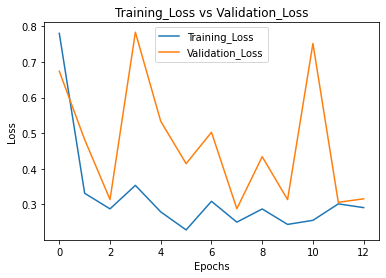

In [ ]:
# plotting training vs validation loss
plt.plot(hist_resnet.history['loss'])
plt.plot(hist_resnet.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training_Loss','Validation_Loss'])
plt.title('Training_Loss vs Validation_Loss')
plt.show()

In [ ]:
# load a model from saved model
from keras.models import load_model
final_model = load_model('Resnet50_model.hdf5')
# estimate loss, accuracy for test_data
loss,acc = final_model.evaluate(test_data)
print('Model Loss:', loss)
print('Model Accuracy:',acc)

20/20 [==============================] - 4s 220ms/step - loss: 0.2877 - accuracy: 0.8830
Model Loss: 0.28771376609802246
Model Accuracy: 0.8830128312110901


In [ ]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
pred =final_model.predict(test_data,verbose=1)

20/20 [==============================] - 4s 215ms/step


In [ ]:
# Identify the predicted classes
prediction = np.argmax(pred, axis=-1)

In [ ]:
conf = confusion_matrix(y_true = test_data.classes, y_pred=prediction)

Confusion matrix, without normalization
[[192  42]
 [ 31 359]]


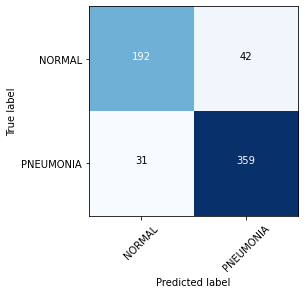

In [ ]:
# visualize confusion matrix graphically
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=conf, classes=cm_plot_labels, title='')

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true = test_data.classes, y_pred = prediction))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       234
           1       0.90      0.93      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



**Inference:**

VGG16          ->> Accuracy - 0.92, Loss - 0.23

Inception V3   ->> Accuracy - 0.88, Loss - 0.34

ResNet50       ->> Accuracy - 0.89, Loss - 0.28

For our task, Since VGG16 has higher accuracy and also lower loss, it is performed well and selected as final model